# Explore and Process Data

## Import Raw Data

In [2]:
# import useful libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# set the path of the raw data
raw_data_path = os.path.join(os.path.pardir, 'data', 'raw')
labeled_file_path = os.path.join(raw_data_path, 'train.csv')
unlabeled_file_path = os.path.join(raw_data_path, 'test.csv')

# read the data with all default parameters
labeled_df = pd.read_csv(labeled_file_path, index_col = None)
unlabeled_df = pd.read_csv(unlabeled_file_path, index_col = None)

In [2]:
# any null missing data?
labeled_df.isnull().any().any() or unlabeled_df.isnull().any().any()

False

## Remove columns with only one value

In [3]:
# any columns with only a single value?
no_var_cols = []
for c in labeled_df.columns:
    if labeled_df[c].nunique() == 1:
        no_var_cols += [c]
        
print(len(no_var_cols), '\n', no_var_cols)

76 
 ['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel111', 'pixel112', 'pixel139', 'pixel140', 'pixel141', 'pixel168', 'pixel196', 'pixel392', 'pixel420', 'pixel421', 'pixel448', 'pixel476', 'pixel532', 'pixel560', 'pixel644', 'pixel645', 'pixel671', 'pixel672', 'pixel673', 'pixel699', 'pixel700', 'pixel701', 'pixel727', 'pixel728', 'pixel729', 'pixel730', 'pixel731', 'pixel754', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759', 'pixel760', 'pixel780', 'pixel781', 'pixel782', 'pixel783']


In [4]:
# great, we can drop approximately 10% of our columns
labeled_df.drop(no_var_cols, axis = 1, inplace = True)
unlabeled_df.drop(no_var_cols, axis = 1, inplace = True)

## Look at column variance

In [5]:
# let's look at the variance of each pixel column
col_var = []
for c in labeled_df.drop(['label'], axis = 1).columns:
    col_var += [labeled_df[c].var()]

Populating the interactive namespace from numpy and matplotlib


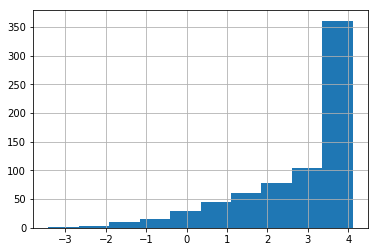

In [6]:
# histogram of log10 of pixel variance
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt

plt.hist(log10(col_var))
plt.grid()
plt.show()

Looks like there are many low-variance columns we could get rid of, but we'll deal with these later with dimensionality reduction techniques like PCA.
 
## Rescale columns to 0-1

In [7]:
# scale pixel values from 0-255 to 0-1
labeled_df.iloc[:,1:] = labeled_df.iloc[:,1:].applymap(lambda x : x / 255)
unlabeled_df.iloc[:,:] = unlabeled_df.iloc[:,:].applymap(lambda x : x / 255)

## Add ImageId column

In [8]:
# images do not have an ImageId column, so create and put it in front
labeled_df['ImageId'] = labeled_df.index + 1
columns = [column for column in labeled_df.columns if column != 'ImageId']
columns = ['ImageId'] + columns
labeled_df = labeled_df[columns]

unlabeled_df['ImageId'] = unlabeled_df.index + 1
columns = [column for column in unlabeled_df.columns if column != 'ImageId']
columns = ['ImageId'] + columns
unlabeled_df = unlabeled_df[columns]

## Split Labeled Data into Train and Test Sets

In [9]:
# train on 80%, test on 20%
# stratify split based on 'label' column
train_df, test_df = train_test_split(labeled_df,
                                     test_size = 0.2,
                                     random_state = 42,
                                     stratify = labeled_df.label)
print(labeled_df.shape, " = ", train_df.shape, " + ", test_df.shape)
print(unlabeled_df.shape)

(42000, 710)  =  (33600, 710)  +  (8400, 710)
(28000, 709)


In [10]:
# make sure stratification is good
print(train_df.label.value_counts() / len(train_df), '\n')
print(test_df.label.value_counts() / len(test_df))

1    0.111518
7    0.104792
3    0.103601
9    0.099702
2    0.099464
6    0.098482
0    0.098393
4    0.096964
8    0.096726
5    0.090357
Name: label, dtype: float64 

1    0.111548
7    0.104762
3    0.103571
9    0.099762
2    0.099405
6    0.098571
0    0.098333
4    0.096905
8    0.096786
5    0.090357
Name: label, dtype: float64


## Save Processed Data

In [11]:
# define file paths
processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
write_train_processed_path = os.path.join(processed_data_path, 'train_processed.csv')
write_test_processed_path = os.path.join(processed_data_path, 'test_processed.csv')
write_unlabeled_processed_path = os.path.join(processed_data_path, 'unlabeled_processed.csv')

In [12]:
# write files
train_df.to_csv(write_train_processed_path, index = False)
test_df.to_csv(write_test_processed_path, index = False)
unlabeled_df.to_csv(write_unlabeled_processed_path, index = False)

## Script for processing data

In [3]:
# create path to the data subfolder of the src folder
# script file name will be 'process_raw_data.py'
process_raw_data_script_file = os.path.join(os.path.pardir, 'src', 'data', 'process_raw_data.py')

In the next block, write and save the script for future use.

In [4]:
%%writefile $process_raw_data_script_file
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import logging # log intermediate steps that have been completed

                
# main function, requires the project directory path
def main(project_dir):
    # get logger
    logger = logging.getLogger(__name__)
    logger.info('processing raw data')
    
    # set the path of the raw data
    raw_data_path = os.path.join(os.path.pardir, 'data', 'raw')
    labeled_file_path = os.path.join(raw_data_path, 'train.csv')
    unlabeled_file_path = os.path.join(raw_data_path, 'test.csv')

    # read the data with all default parameters
    labeled_df = pd.read_csv(labeled_file_path, index_col = None)
    unlabeled_df = pd.read_csv(unlabeled_file_path, index_col = None)
    logger.info('raw data has been retrieved')
    
    # drop columns with only a single value
    for c in labeled_df.columns:
        if labeled_df[c].nunique() == 1:
            labeled_df.drop([c], axis = 1, inplace = True)
            unlabeled_df.drop([c], axis = 1, inplace = True)
    logger.info('variance zero columns dropped')
    
    # rescale columns from 0-255 to 0-1
    labeled_df.iloc[:,1:] = labeled_df.iloc[:,1:].applymap(lambda x : x / 255)
    unlabeled_df.iloc[:,:] = unlabeled_df.iloc[:,:].applymap(lambda x : x / 255)
    logger.info('columns scaled to 0-1')
    
    # add ImageId column, reorder so it's first
    labeled_df['ImageId'] = labeled_df.index + 1
    columns = [column for column in labeled_df.columns if column != 'ImageId']
    columns = ['ImageId'] + columns
    labeled_df = labeled_df[columns]

    unlabeled_df['ImageId'] = unlabeled_df.index + 1
    columns = [column for column in unlabeled_df.columns if column != 'ImageId']
    columns = ['ImageId'] + columns
    unlabeled_df = unlabeled_df[columns]
    logger.info('ImageId column added to the front')
    
    # 80-20 train-test split, stratify split based on 'label' column
    train_df, test_df = train_test_split(labeled_df,
                                         test_size = 0.2,
                                         random_state = 42,
                                         stratify = labeled_df.label)
    logger.info('performed 50-50 train-test split')
    
    # define file paths for processed data
    processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
    write_train_processed_path = os.path.join(processed_data_path, 'train_processed.csv')
    write_test_processed_path = os.path.join(processed_data_path, 'test_processed.csv')
    write_unlabeled_processed_path = os.path.join(processed_data_path, 'unlabeled_processed.csv')
    
    # write processed data to files
    train_df.to_csv(write_train_processed_path, index = False)
    test_df.to_csv(write_test_processed_path, index = False)
    unlabeled_df.to_csv(write_unlabeled_processed_path, index = False)
    logger.info('processed data written to files')
    
    
    
if __name__ == '__main__':
    # getting script file name and append parent directory twice
    # helps to move two levels up since path is /digit_recognizer/src/data
    project_dir = os.path.join(os.path.dirname(__file__), os.pardir, os.pardir)
    
    # set up logger
    log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level = logging.INFO, format = log_fmt)
    
    # call main function
    main(project_dir)

Overwriting ../src/data/process_raw_data.py


Run the script

In [5]:
!python $process_raw_data_script_file

2018-08-09 16:19:02,366 - __main__ - INFO - processing raw data
2018-08-09 16:19:12,940 - __main__ - INFO - raw data has been retrieved
2018-08-09 16:19:40,686 - __main__ - INFO - variance zero columns dropped
2018-08-09 16:21:33,761 - __main__ - INFO - columns scaled to 0-1
2018-08-09 16:21:35,483 - __main__ - INFO - ImageId column added to the front
2018-08-09 16:21:35,830 - __main__ - INFO - performed 50-50 train-test split
2018-08-09 16:22:51,623 - __main__ - INFO - processed data written to files
